In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

from PIL import Image
from pylab import rcParams
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt

import os
import shutil
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# from google.colab import files
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Loading data

**Let's see what the data in the pandas table looks like**

In [6]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

In [8]:
train_csv = pd.read_csv(r"DatasetV2\train\Hexacore-Train.csv")
test_csv = pd.read_csv(r"DatasetV2\test\Hexacore-Test.csv")

In [18]:
train_csv.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,1,...,0,1,0,26,99,86,37,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,109,39,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,1,0,19,121,62,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,0,0,0,0,0,0,...,0,0,0,92,155,0,0,0,0,0
6,9,0,0,0,0,0,0,0,0,0,...,0,0,5,0,47,138,140,53,0,0
7,2,0,0,0,0,0,0,2,0,75,...,0,0,0,155,203,148,0,0,0,0
8,6,0,0,0,0,0,0,0,0,0,...,110,137,127,65,0,113,127,68,0,0
9,4,0,0,0,0,0,0,0,2,2,...,0,0,2,0,0,121,128,47,0,0


In [9]:
## Data Mnist Image Folder
train_transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.Compose([transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip()]),
        transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()])
    ]),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    ])

train_transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    ])

train_transform3 = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    ])

train_transform4 = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, scale=(0.02, 0.2)),
    ])

test_transform = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    ])

## import data
train_set1 = FashionDataset(train_csv,transform=train_transform1)
train_set2 = FashionDataset(train_csv,transform=train_transform2)
train_set3 = FashionDataset(train_csv,transform=train_transform3)
train_set4 = FashionDataset(train_csv,transform=train_transform4)
train_sets = torch.utils.data.ConcatDataset([train_set1, train_set2, train_set3, train_set4])

test_set = FashionDataset(test_csv,transform=test_transform)

train_set, val_set = torch.utils.data.random_split(train_sets, [int(len(train_sets) * 0.9), int(len(train_sets) * 0.1)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                        batch_size = 100,
                                        shuffle = True)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                        batch_size = 100)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [10]:
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

{'train': 228240, 'val': 25360}


**Let's see what the images look like**

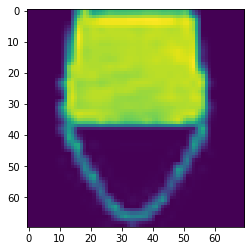

In [11]:
i = np.random.randint(50)
x, y = next(iter(train_dataloader))
plt.imshow(x[i].permute(1, 2, 0))

In [24]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'Hat']

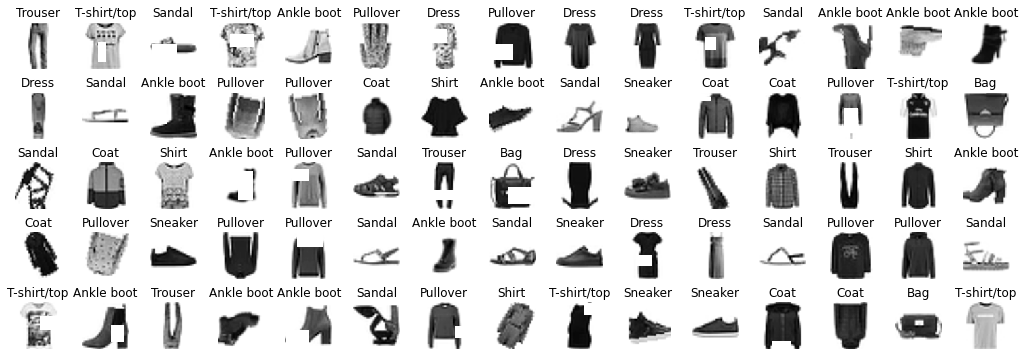

In [25]:
n_rows = 5
n_cols = 15
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
x,y = next(iter(train_dataloader))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x[index].permute(1,2,0), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Model

In [13]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, num_classes)
          )

      if init_weights:
        self.initialize_weights()

  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

cfgs: Dict[str, List[Union[int, str]]] = {
    'A': [64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 1024, 1024, 1024, 'M'],
    'B': [64, 'M', 128, 'M', 256, 'M', 512, 'M', 1024, 'M'],
    'firstPadding':2
}

def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Module] = []
  in_channels = 3
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 11)
model = model.to(device)

In [5]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=1)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): PReLU(num_parameters=1)
  

**Loss function, Optimizer, Scheduler**

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

# Train

In [9]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(float(epoch_loss))
      accuracies[phase].append(float(epoch_acc))
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

**Launching training**

In [10]:
epochs = 10
torch.cuda.empty_cache()

model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.6025297746731876, accuracy0.7896656134807793
val - loss:0.3866519467643275, accuracy0.8661532385466034
Time: 26.0m 23.361172199249268s
Epoch: 2/10
train - loss:0.3422861952535391, accuracy0.8848955590661751
val - loss:0.2917913682699957, accuracy0.8964454976303317
Time: 51.0m 54.15425515174866s
Epoch: 3/10
train - loss:0.2751303803942717, accuracy0.9070168509741969
val - loss:0.24782347024122686, accuracy0.9141785150078988
Time: 77.0m 27.05570340156555s
Epoch: 4/10
train - loss:0.23747571070013349, accuracy0.9201992276636827
val - loss:0.2219247871489039, accuracy0.925078988941548
Time: 102.0m 59.58335995674133s
Epoch: 5/10
train - loss:0.156264877877966, accuracy0.9454361944883272
val - loss:0.14676713104849742, accuracy0.9472353870458136
Time: 128.0m 31.85336470603943s
Epoch: 6/10
train - loss:0.13434499461313015, accuracy0.9536993154291732
val - loss:0.13528512341027718, accuracy0.952172195892575
Time: 154.0m 5.799724102020264s
Epoch: 7/10
train - loss:0.1

**Visualization**

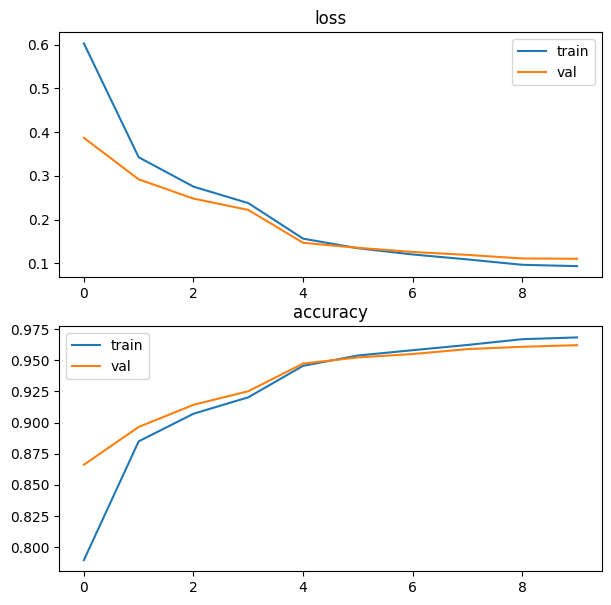

In [11]:
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], accuracies['train'], label ='train')
axs[1].plot([x for x in range(epochs)], accuracies['val'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

## Save Model and Load Model

In [19]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%m-%d_%H-%M-%S")

DIR_NAME = "ModelsSave/RGB"
if os.path.exists(DIR_NAME) == False:
    os.mkdir(DIR_NAME)

# Save model
torch.save(
    model.state_dict(),
    DIR_NAME+'/model={}-{:.4f}.pth'.format(current_time, max(accuracies['val']))
)

In [14]:
model_path = 'Model\RGB\Main-model=2022-11-26_00-13-47-0.9620.pth'

model = selfDefineVgg(cfgs, 'A', True, 11)
model = model.to(device)

state_dict = torch.load(model_path)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

# Test

**Uploading the data**

In [16]:
loadersq=  DataLoader(test_set, batch_size=100, shuffle = True, num_workers=4)

**Creating a dictionary with the size of the test dataset.**

In [17]:
dataset_sizesq = len(test_set)
dataset_sizesq

10400

**Predictions**

In [11]:
corr = 0
predictions_list = []
labels_list = []

def output_label(label):
    output_mapping = { # From New Dataset
                 0: "Ankle Bot",
                 1: "Bag",
                 2: "Coat",
                 3: "Dress",
                 4: "Hat",
                 5: "Pullover",
                 6: "Sandal",
                 7: "Shirt",
                 8: "Sneaker",
                 9: "T-shirt-top",
                 10: "Trouser"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

with torch.no_grad():
    for data in loadersq:
        images, labels = data
        labels_list.append(labels)
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        _, predicted = torch.max(y_pred, 1)
        predictions_list.append(predicted)
        corr += torch.sum(predicted == labels.data)

print(f"Test accuracy: {corr/dataset_sizesq}")

Test accuracy: 0.9474757313728333


In [9]:
class_correct = [0. for _ in range(11)]
total_correct = [0. for _ in range(11)]

with torch.no_grad():
    for images, labels in loadersq:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(11):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of Ankle Bot: 97.80%
Accuracy of Bag: 99.20%
Accuracy of Coat: 92.30%
Accuracy of Dress: 94.50%
Accuracy of Hat: 100.00%
Accuracy of Pullover: 91.40%
Accuracy of Sandal: 99.00%
Accuracy of Shirt: 84.30%
Accuracy of Sneaker: 98.30%
Accuracy of T-shirt-top: 89.50%
Accuracy of Trouser: 99.20%


# Confusion Matrix

In [ ]:
from itertools import chain

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [11]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

C:\Users\Overl\OneDrive\Desktop\devlop\FP-AI-TheBois\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Classification report for CNN :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.99      0.99      0.99      1000
           2       0.93      0.92      0.92      1000
           3       0.94      0.95      0.95      1000
           4       1.00      1.00      1.00       300
           5       0.92      0.92      0.92      1000
           6       1.00      0.99      0.99      1000
           7       0.82      0.84      0.83      1000
           8       0.97      0.98      0.98      1000
           9       0.91      0.89      0.90      1000
          10       0.99      0.99      0.99      1000

    accuracy                           0.95     10300
   macro avg       0.95      0.95      0.95     10300
weighted avg       0.95      0.95      0.95     10300




## Predict with Jury Test

In [16]:
from torchvision.transforms import functional
# Show Function for image tensor
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [17]:
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np


def pre_image(image_path,model):
   transform_norm = transforms.Compose([
       transforms.Resize((70,70)),
       transforms.ToTensor()
       ])

   # Read Image
   img = Image.open(image_path).convert('L')
   img = ImageOps.invert(img).convert("RGB")
   img_normalized = transform_norm(img).float()
   show(img_normalized)
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to(device)

   print("Shape Image:",img_normalized.shape)
   with torch.no_grad(): # Predict Image
      model.eval()
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = ["Ankle Bot", "Bag", "Coat", "Dress", "Hat","Pullover", "Sandal", "Shirt", "Sneaker", "T-shirt/Top", "Trouser"]
      class_name = classes[index]
      return class_name

Shape Image: torch.Size([1, 3, 70, 70])
Hat


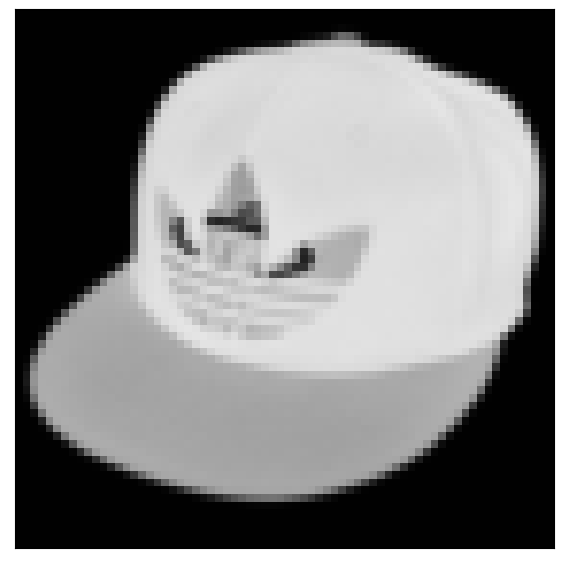

In [18]:
# Test from local
test_file_path = "Jury_test/hat_3.jpg"
predict_class = pre_image(test_file_path, model)
print(predict_class)